# Speech emotion recognition using 1-dimensional ConvNN

In this experiment i tried to recognize emotion in short voice message (< 3s). I will use 4 datasets with some english phrases,
which were voiced by professional actors: Ravee, Crema, Savee and Tess.

#### First, lets define SER i.e. Speech Emotion Recognition.

*Speech Emotion Recognition*, abbreviated as *SER*, is the act of attempting to recognize human emotion and affective states from speech.
This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon
that animals like dogs and horses employ to be able to understand human emotion

**Datasets used in this project** contains ~7 types of main emotions: *Happy, Fear, Angry, Disgust, Surprised, Sad or Neutral.*


## Importing libraries

In [1]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools

In [2]:
# Paths to
Ravdess = "../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"
Crema = "../input/speech-emotion-recognition-en/Crema"
Savee = "../input/speech-emotion-recognition-en/Savee"
Tess = "../input/speech-emotion-recognition-en/Tess"

## Data preparation

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

In [4]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [5]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotion,Path
0,surprise,../input/speech-emotion-recognition-en/Ravdess...
1,neutral,../input/speech-emotion-recognition-en/Ravdess...
2,disgust,../input/speech-emotion-recognition-en/Ravdess...
3,disgust,../input/speech-emotion-recognition-en/Ravdess...
4,neutral,../input/speech-emotion-recognition-en/Ravdess...


### Crema dataset

In [6]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,disgust,../input/speech-emotion-recognition-en/Crema/1...
1,happy,../input/speech-emotion-recognition-en/Crema/1...
2,happy,../input/speech-emotion-recognition-en/Crema/1...
3,disgust,../input/speech-emotion-recognition-en/Crema/1...
4,disgust,../input/speech-emotion-recognition-en/Crema/1...


### TESS dataset

In [7]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

,Emotion,Path
0,fear,../input/speech-emotion-recognition-en/Tess/YA...
1,fear,../input/speech-emotion-recognition-en/Tess/YA...
2,fear,../input/speech-emotion-recognition-en/Tess/YA...
3,fear,../input/speech-emotion-recognition-en/Tess/YA...
4,fear,../input/speech-emotion-recognition-en/Tess/YA...


In [8]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

,Emotion,Path
0,happy,../input/speech-emotion-recognition-en/Savee/J...
1,fear,../input/speech-emotion-recognition-en/Savee/K...
2,happy,../input/speech-emotion-recognition-en/Savee/D...
3,disgust,../input/speech-emotion-recognition-en/Savee/D...
4,angry,../input/speech-emotion-recognition-en/Savee/K...


In [9]:
# Let's concat all datasets together for doing some analysis
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(12162, 2)

In [10]:
df.head(10)

,Emotion,Path
0,surprise,../input/speech-emotion-recognition-en/Ravdess...
1,neutral,../input/speech-emotion-recognition-en/Ravdess...
2,disgust,../input/speech-emotion-recognition-en/Ravdess...
3,disgust,../input/speech-emotion-recognition-en/Ravdess...
4,neutral,../input/speech-emotion-recognition-en/Ravdess...
5,fear,../input/speech-emotion-recognition-en/Ravdess...
6,sad,../input/speech-emotion-recognition-en/Ravdess...
7,neutral,../input/speech-emotion-recognition-en/Ravdess...
8,neutral,../input/speech-emotion-recognition-en/Ravdess...
9,happy,../input/speech-emotion-recognition-en/Ravdess...


In [11]:
%matplotlib inline

plt.style.use("ggplot")

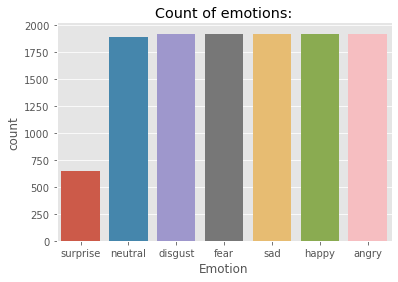

In [12]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [13]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

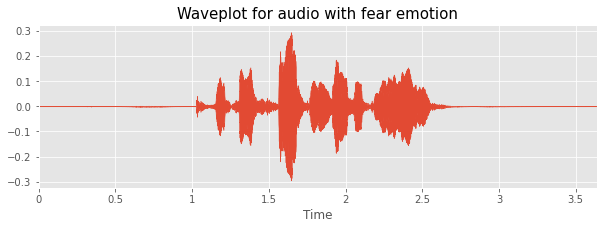

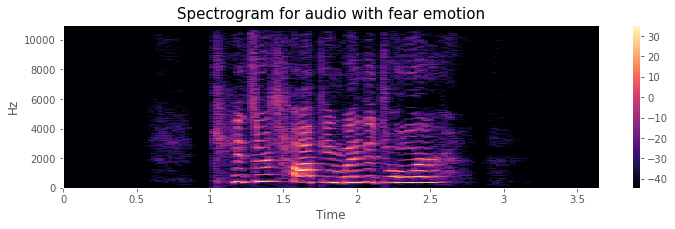

In [14]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


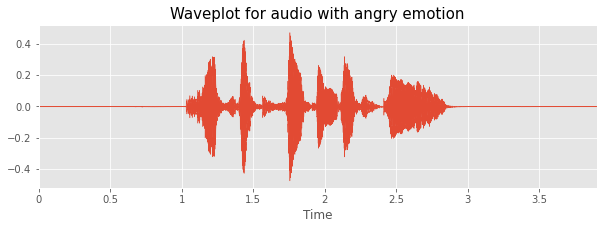

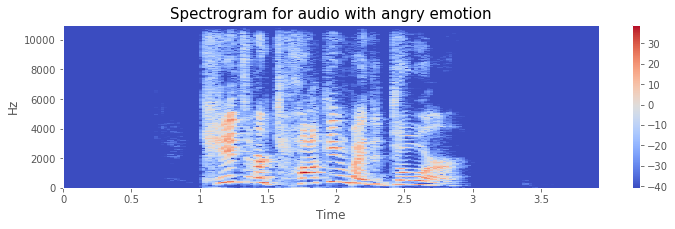

In [15]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

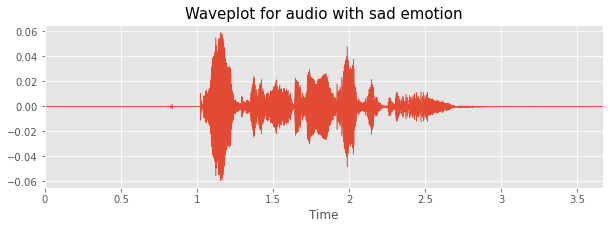

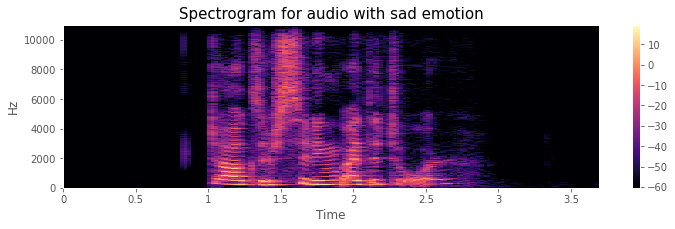

In [16]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [17]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [18]:
df.head()

,Emotion,Path
0,surprise,../input/speech-emotion-recognition-en/Ravdess...
1,neutral,../input/speech-emotion-recognition-en/Ravdess...
2,disgust,../input/speech-emotion-recognition-en/Ravdess...
3,disgust,../input/speech-emotion-recognition-en/Ravdess...
4,neutral,../input/speech-emotion-recognition-en/Ravdess...


In [19]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

1. Simple audio

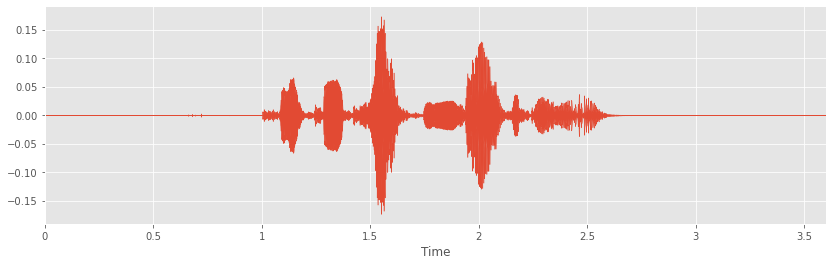

In [20]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

2. Noised audio

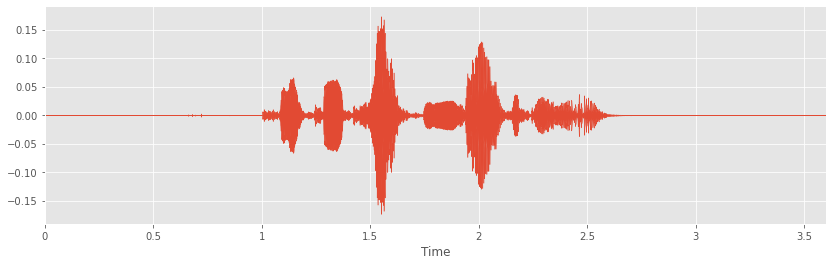

In [21]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)


3. Stretching


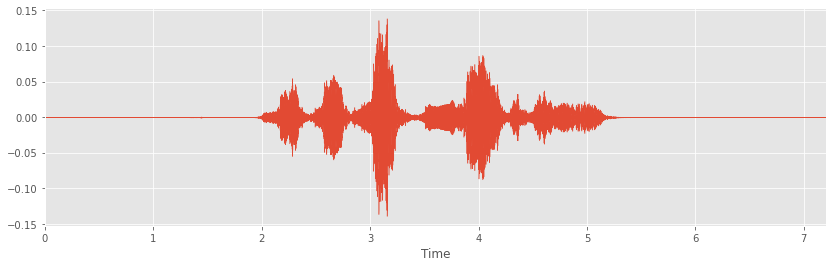

In [22]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)


4. Shifting


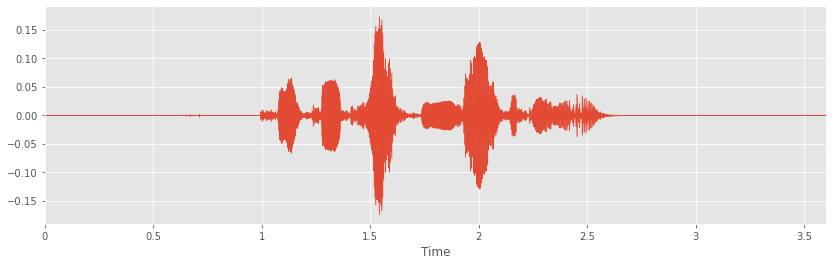

In [23]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


5. Pitching

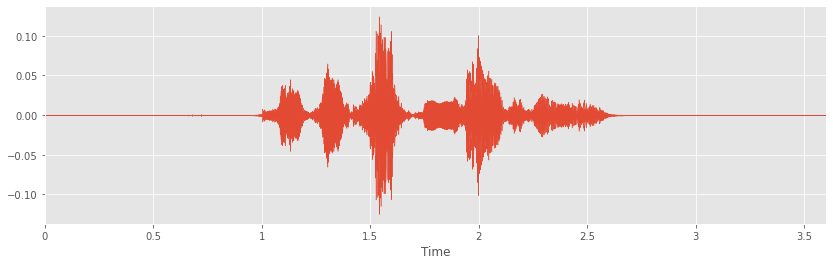

In [24]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

For data augmentation I will use noise and pitch and combination with both of it.


## Feature extraction

#### There are some features may be useful:

In [25]:
n_fft = 2048
hop_length = 512

In [26]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

#### Checking data formats:

In [27]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

55125

In [28]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)


ZCR:  (108,)
Energy:  (108,)
Entropy of Energy : (108,)
RMS : (108,)
Spectral Centroid : (108,)
Spectral Flux:  ()
Spectral Rollof:  (108,)
Chroma STFT:  (1296,)
MelSpectrogram:  (13824,)
MFCC:  (2160,)


In [29]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [30]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [31]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
2800 sampl

save features as DataFrame for further processing:

In [32]:
features_path = "./features.csv"

In [33]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.342285,0.479492,0.573730,0.458008,0.376465,0.301758,0.269043,0.256348,0.252441,0.252930,...,-1.800944,-1.947110,-1.746312,-1.296943,-0.702259,-0.045278,0.624514,1.286767,1.931510,surprise
1,0.247070,0.366699,0.483887,0.489746,0.465820,0.440430,0.420898,0.386230,0.388184,0.389648,...,-1.383487,5.520630,2.865345,2.242731,-0.002066,-1.938387,-4.299829,-3.357496,-0.057793,surprise
2,0.306641,0.425293,0.530762,0.449219,0.371582,0.317871,0.272461,0.263184,0.254395,0.250488,...,2.219517,2.683231,3.056429,3.194887,3.042258,2.629266,2.052903,1.442903,0.924656,surprise
3,0.258789,0.388184,0.502441,0.493652,0.480469,0.462402,0.466309,0.451172,0.449707,0.461914,...,5.070818,3.602048,3.620002,-2.480145,-1.962114,-7.283421,-8.287120,-1.374644,0.972637,surprise
4,0.420898,0.631348,0.833008,0.837891,0.831055,0.821777,0.819824,0.810059,0.804688,0.627930,...,2.861256,2.993450,2.379827,1.030240,-0.787677,-2.658594,-4.171967,-5.034144,-5.102701,neutral


In [34]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(48648, 2377)


In [35]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape


0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(48648, 2377)

In [36]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.342285,0.479492,0.573730,0.458008,0.376465,0.301758,0.269043,0.256348,0.252441,0.252930,...,-1.800944,-1.947110,-1.746312,-1.296943,-0.702259,-0.045278,0.624514,1.286767,1.931510,surprise
1,0.247070,0.366699,0.483887,0.489746,0.465820,0.440430,0.420898,0.386230,0.388184,0.389648,...,-1.383487,5.520630,2.865345,2.242731,-0.002066,-1.938387,-4.299829,-3.357496,-0.057793,surprise
2,0.306641,0.425293,0.530762,0.449219,0.371582,0.317871,0.272461,0.263184,0.254395,0.250488,...,2.219517,2.683231,3.056429,3.194887,3.042258,2.629266,2.052903,1.442903,0.924656,surprise
3,0.258789,0.388184,0.502441,0.493652,0.480469,0.462402,0.466309,0.451172,0.449707,0.461914,...,5.070818,3.602048,3.620002,-2.480145,-1.962114,-7.283421,-8.287120,-1.374644,0.972637,surprise
4,0.420898,0.631348,0.833008,0.837891,0.831055,0.821777,0.819824,0.810059,0.804688,0.627930,...,2.861256,2.993450,2.379827,1.030240,-0.787677,-2.658594,-4.171967,-5.034144,-5.102701,neutral


## Data preparation



In [37]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [38]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y


['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38918, 2376), (9730, 2376), (38918, 7), (9730, 7))

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [41]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((35026, 2376), (9730, 2376), (3892, 2376), (35026, 7), (9730, 7), (3892, 7))

In [42]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(35026, 2376, 1)

### Let's define model:

In [43]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)


In [44]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [45]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [46]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])



In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 594, 256)          6

In [48]:
EPOCHS = 50
batch_size = 64

In [49]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
548/548 [==============================] - 91s 166ms/step - loss: 1.4679 - acc: 0.4570 - f1_m: 0.3867 - val_loss: 1.4771 - val_acc: 0.4337 - val_f1_m: 0.4113
Epoch 2/50
548/548 [==============================] - 90s 165ms/step - loss: 1.0730 - acc: 0.5863 - f1_m: 0.5454 - val_loss: 1.1452 - val_acc: 0.5779 - val_f1_m: 0.5565
Epoch 3/50
548/548 [==============================] - 90s 165ms/step - loss: 0.9030 - acc: 0.6541 - f1_m: 0.6311 - val_loss: 0.9771 - val_acc: 0.6285 - val_f1_m: 0.5990
Epoch 4/50
548/548 [==============================] - 90s 165ms/step - loss: 0.7364 - acc: 0.7211 - f1_m: 0.7093 - val_loss: 0.8837 - val_acc: 0.6881 - val_f1_m: 0.6801
Epoch 5/50
548/548 [==============================] - 90s 165ms/step - loss: 0.5591 - acc: 0.7932 - f1_m: 0.7882 - val_loss: 0.9825 - val_acc: 0.6878 - val_f1_m: 0.6879
Epoch 6/50
548/548 [==============================] - 90s 165ms/step - loss: 0.4052 - acc: 0.8545 - f1_m: 0.8536 - val_loss: 0.6913 - val_acc: 0.7559 - val

305/305 [==============================] - 7s 23ms/step - loss: 0.2170 - acc: 0.9603 - f1_m: 0.9608
Accuracy of our model on test data :  96.03288769721985 %


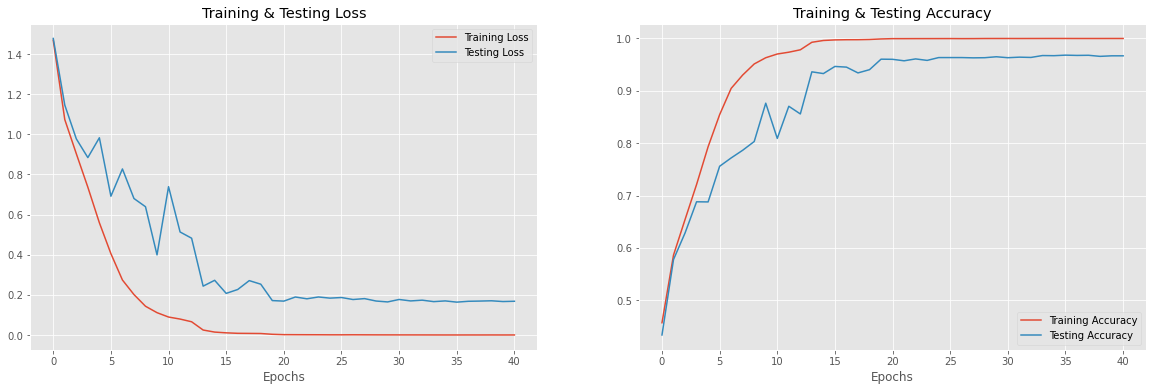

In [50]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [51]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 1, ..., 4, 5, 2])

In [52]:
y_check = np.argmax(y_test, axis=1)
y_check

array([0, 0, 1, ..., 4, 5, 2])

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [54]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1431   10   14   16    9    0    4]
 [  17 1485   14   12   13   16    1]
 [  12    3 1446   12   16   13    3]
 [  26   15   22 1530    9    7   10]
 [  10   19    6    6 1502   14    1]
 [   4   14   12    3   13 1432    0]
 [   2    1    1    4    1    1  518]]


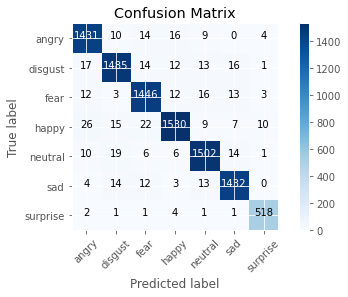

In [55]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [56]:
path_to_model = "./res_model.h5"

model.save(path_to_model)